In [ ]:
#export
from triplet_loss import *
from video_block import *

In [ ]:
#export
from fastai.vision.all import *

import torch
import torch.nn as nn

from pathlib import Path

import pandas as pd
from functools import partial

from sklearn.metrics import silhouette_score

import os

In [ ]:
from modules_th.triplet_loss import *
from modules_th.video_block import *

In [ ]:
#export 
torch.cuda.set_device(1)

In [ ]:
#export
adrian = True
path_to_save_experiments = Path('/mnt/data/adrianlopez/experiments on images 1') if adrian else Path('/mnt/data/eugeniomarinelli/experiments on images')

In [ ]:
df = pd.read_csv(path_to_save_experiments/'TL'/'losses'/'CEL-TL_ p=cos alpha=0.5 margin=0.2_.csv')
EMA(df.silh_score).plot()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/adrianlopez/experiments on images 1/TL/losses/CEL-TL_ p=cos alpha=0.5 margin=0.2_.csv'

In [ ]:
#export
path = untar_data(URLs.CALTECH_101)
items = pd.read_csv(path_to_save_experiments/'train_CALTECH101.csv')#.loc[:1000]
lbls = items['lbls']

splits = ColSplitter(col='val')(items)

train_lbls = lbls[splits[0]]
val_lbls = lbls[splits[1]]

In [ ]:
#export
img_pl = [lambda x: x['img_files'], PILImage.create, Resize(512)]
pls = [img_pl, img_pl, [lambda x: x['lbls'], Categorize()]]

dsets = Datasets(items, pls,
                 splits=splits)

In [ ]:
#export
n_el, n_lbl = 8, 8
dls = dsets.dataloaders(bs=n_el*n_lbl,
                        after_item=ToTensor(),
                        after_batch=[IntToFloatTensor(), 
                                     Normalize.from_stats(*imagenet_stats),
                                     *aug_transforms(size=128)])

dls.valid.shuffle = True
dls.train.shuffle_fn = UniformizedShuffle(train_lbls, n_el=n_el, n_lbl=n_lbl)
dls.valid.shuffle_fn = UniformizedShuffle(val_lbls, n_el=n_el, n_lbl=n_lbl)

In [ ]:
#export
def make_dir(fname):
    if not os.path.isdir(fname): os.mkdir(fname)

def set_kwrgs(loss_name, alpha, p, margin):
    kwrgs = {}
    if loss_name != 'CEL': kwrgs['p'] = p
    if loss_name in ['CEL-TL', 'CEL-SCL']: kwrgs['alpha'] = alpha
    if loss_name in ['TL', 'CEL-TL']: kwrgs['margin'] = margin
    return kwrgs

def set_model(loss_name, dls, lin_ftrs):
    print(loss_name)
    ModelClass = nn.Sequential if loss_name in ['CEL', 'TL', 'SCL'] else MixedLossModel
    head = create_head(512*2, lin_ftrs[0]) if loss_name in ['TL', 'SCL'] else create_head(512*2, dls.c, lin_ftrs=lin_ftrs) 
    encoder = create_body(resnet34, cut=-2)
    model = ModelClass(encoder, head)
    return model
    
def set_cbs(learn, loss_name, nviews):
    if loss_name in ['CEL-SCL','CEL-TL']: learn.add_cb(MixedLossRecorder()) #When we use a mixed loss we put the MixedLossTracker
    if loss_name in ['CEL-SCL','SCL'   ]: learn.add_cbs(ContrastiveCallback(nviews))
    else: 
        def f(self): self.learn.yb = (self.y.repeat(nviews),)
        learn.add_cbs([Callback(before_batch=cat_views), 
                       Callback(before_batch=f)])

def save_model(learn, loss_name, kwrgs):
    model_name = f'{loss_name}_{dict2str(kwrgs)}_.pt'
    make_dir(path_loss/'models')    
    torch.save(learn.model, path_loss/'models'/model_name)
               
def save_losses(path_loss, loss_name, kwrgs):
    make_dir(path_loss/'losses')
    if isinstance(loss_func, MixedLoss):
        torch.save(tensor(learn.ml_recorder.sl_losses[0]), path_loss/'losses'/f'train_sl_{dict2str(kwrgs)}_.pt')
        torch.save(tensor(learn.ml_recorder.sl_losses[1]), path_loss/'losses'/f'val_sl_{dict2str(kwrgs)}_.pt')
        torch.save(tensor(learn.ml_recorder.cel_losses[0]), path_loss/'losses'/f'train_cel_{dict2str(kwrgs)}_.pt')
        torch.save(tensor(learn.ml_recorder.cel_losses[1]), path_loss/'losses'/f'val_cel_{dict2str(kwrgs)}_.pt')
    else: 
        torch.save(tensor(learn.recorder.losses), path_loss/'losses'/f'val_{loss_name}_{dict2str(kwrgs)}_.pt')

def silh_score(pred,y):
    if isinstance(pred,tuple):
        _,pred = pred        
    if len(pred.shape) > 2:
        pred = torch.cat(pred.unbind(dim=1))
    y=y.repeat(pred.size(0)//y.size(0))
    return skm_to_fastai(silhouette_score,flatten=False)(y,pred)

def dict2str(d):
    s = ''
    for k, v in d.items(): s += f' {k}={v}'
    return s

def EMA(y, w=0.1):
    S = np.zeros_like(y)
    S[0] = y[0]
    for i in range(1,len(y)):
        S[i] = w*y[i]+(1-w)*S[i-1]
    return type(y)(S)

In [ ]:
#export
nepochs = 100
nviews = len(pls) - 1

loss_names = [#'CEL',
#               'TL',
              'SCL']#,
#               'CEL-TL',
#               'CEL-SCL']

LossClasses = [#CrossEntropyLossFlat,
#                TripletLoss,
               SupConLoss]#,
#                partial(MixedLoss, TripletLoss),
#                partial(MixedLoss, SupConLoss)]
ps = ['cos']#, 2]
margins = [0.2]
alphas = [0.5]#, 1, 2]

# for aug in [False, True]:
#     if aug: [dls.after_batch.add(tfm) for tfm in aug_transforms(128)]
for loss_name, LossClass in zip(loss_names, LossClasses):
    break
    path_loss = path_to_save_experiments/f'{loss_name}'
    make_dir(path_loss)
    make_dir(path_loss/'losses')
    kwrgs = {}
    for k, alpha in enumerate(alphas):
        if loss_name=='CEL'and k > 0: break
        for i, margin in enumerate(margins):
            if loss_name in ['CEL','CEl-SCL','SCL'] and i > 0: break # Without this conditional we would train the CEL/SCL models once per every margin,
                                                                     # even though they actually don't use the margin
            for j, p in enumerate(ps):
                if loss_name=='CEL' and j > 0: break

                kwrgs = set_kwrgs(loss_name, alpha, p, margin)
                loss_func = LossClass(**kwrgs)

                model = set_model(loss_name, dls, lin_ftrs=[128])
                    
                learn = Learner(dls, 
                                model, 
                                loss_func=loss_func, 
                                splitter=splitter, 
                                metrics=silh_score if loss_name in ['TL', 'SCL'] else [mixed_accuracy, silh_score])

                make_dir(path_loss/'losses')
                learn.add_cb(CSVLogger(path_loss/'losses'/f'{loss_name}_{dict2str(kwrgs)}_.csv'))
                
                set_cbs(learn, loss_name, nviews)
                
                learn.fine_tune(nepochs)
                save_model(learn, loss_name, kwrgs) #.export(path_loss/'models'/model_name)

                save_losses(path_loss, loss_name, kwrgs)

In [ ]:
path = path_to_save_experiments/'TL'/'losses'
p = path.ls()[2]
p

Path('/mnt/data/adrianlopez/experiments on images 1/TL/losses/TL_ p=2 margin=0.2_.csv')

<AxesSubplot:>

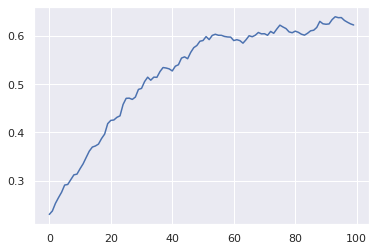

In [ ]:
df = pd.read_csv(p)
EMA(df.silh_score, 0.2).plot() #iloc[-1]

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=0.0008317637839354575)

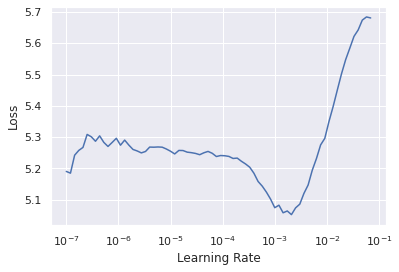

In [ ]:
model = set_model(loss_name, dls, lin_ftrs=[128])

learn = Learner(dls, 
                model, 
                loss_func=loss_func, 
                splitter=splitter, 
                metrics=silh_score if loss_name in ['TL', 'SCL'] else [mixed_accuracy, silh_score])

set_cbs(learn, loss_name, nviews)

learn.lr_find()

In [2]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_losses_tmp.ipynb.
Converted 02_inflator.ipynb.
Converted 03_video_block.ipynb.
Converted 05_charades.ipynb.
Converted 07_read_video_function.ipynb.
Converted 08_transformer.ipynb.
Converted 09_lr_schedule.ipynb.
Converted 10_experiments_on_images.ipynb.
Converted 11_create_embeddings.ipynb.
Converted CALTECH101_MixedLoss.ipynb.
Converted CALTECH101_singleloss.ipynb.
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
 
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e


AttributeError: 'NoneType' object has no attribute 'start'

In [ ]:
# default_exp experiments_on_images